# Random tuner to select best fine tuned model

# 1. Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7544341381590065659
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17394047310310032594
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!pip install tensorflow-addons --quiet
!pip install keras-tuner --quiet

In [ ]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from keras.applications.vgg19 import VGG19
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.applications.vgg19 import preprocess_input
import tensorflow_addons as tfa
import os
import tempfile

import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner import HyperModel

from keras.utils.vis_utils import plot_model

In [ ]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'


#2. Input Pipeline

In [ ]:
def read_labels( pathtoCSV ):
  labels_csv = pd.read_csv(pathtoCSV + 'Train_Val_Reshuffle_SINGLE.csv',dtype=str)
  labels_csv['Class'] = labels_csv['Class'].astype(int)
  classes_zero = labels_csv[labels_csv['Class'] == 0]
  classes_one = labels_csv[labels_csv['Class'] == 1]
  bal = abs(int(len(classes_one) - len(classes_zero)))
  labels_csv.drop((labels_csv.query('Class== 0').sample(n=bal).index),inplace = True)
  return labels_csv

In [ ]:
labels_csv = read_labels(pathtoCSV)

In [ ]:
def image_generator(pathtoImages ):
  train_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  val_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_csv['Class'] = labels_csv['Class'].astype(str)
  labels_csv['File_name'] = labels_csv['File_Name'].astype(str)


  train_generator = train_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Train',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )

  val_generator = val_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Validation',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  return train_generator, val_generator


train_generator, val_generator = image_generator(pathtoImages)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 469 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1665 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1665 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


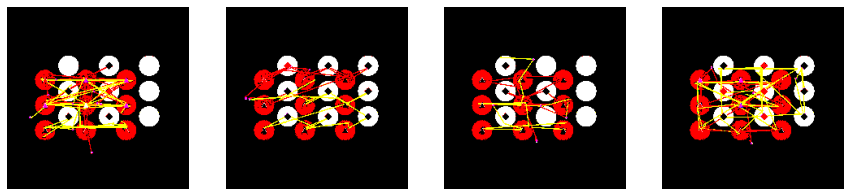

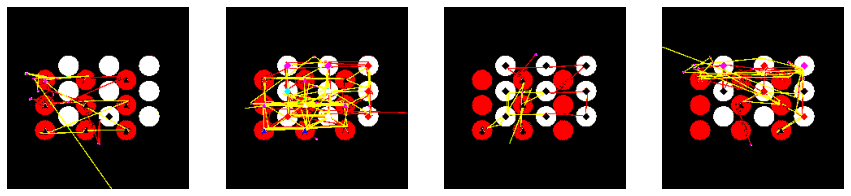

In [ ]:
# plotting train images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  # convert to unsigned integers for plotting
  image = next(train_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

# plotting val images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(val_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

#3. Rebuild best model found by Bayesian Tuner

Best model retrieved by Bayesian tuner:\
units: 1024\
dropout: 0.5000000000000001\
Score: 0.731182813644409


In [ ]:
# Define early-stopping:
early_stopping_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4, 
    mode='auto',
    restore_best_weights=True)

In [ ]:
# Define Metrics:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5),
]

In [ ]:
# Original code source for regularizer: https://sthalles.github.io/keras-regularizer/

def build_model():
  base_model = VGG19(weights='imagenet', include_top=False)
  for layers in base_model.layers:
    layers.trainable=False
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dense(1024,activation='relu')(x)
  x=Dropout(0.5000000000000001)(x)
  output=Dense(1,activation='sigmoid')(x)
  model=Model(inputs=base_model.input,outputs=output)
  regularizer=tf.keras.regularizers.L1L2(1e-5)
  if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
    print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
    return model

  for layer in model.layers:
    for attr in ['kernel_regularizer']:
      if hasattr(layer, attr):
        setattr(layer, attr, regularizer)

  # When we change the layers attributes, the change only happens in the model config file
  model_json = model.to_json()

  # Save the weights before reloading the model.
  tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
  model.save_weights(tmp_weights_path)

  # load the model from the config
  model = tf.keras.models.model_from_json(model_json)
    
  # Reload the model weights
  model.load_weights(tmp_weights_path, by_name=True)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=100000, decay_rate=0.75, staircase=True)
  opt = SGD(learning_rate = lr_schedule, momentum=0.99) 
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics= METRICS)
  return model

model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
history = model.fit(
    train_generator,
    batch_size = 16,
    epochs = 30,
    callbacks= early_stopping_1,
    validation_data = val_generator,
    shuffle = True
)

Epoch 1/30
105/105 [==============================] - 803s 8s/step - loss: 2.9028 - tp: 443.0000 - fp: 389.0000 - tn: 440.0000 - fn: 393.0000 - accuracy: 0.5303 - precision: 0.5325 - recall: 0.5299 - auc: 0.5372 - f1_score: 0.5312 - val_loss: 2.0564 - val_tp: 136.0000 - val_fp: 65.0000 - val_tn: 173.0000 - val_fn: 95.0000 - val_accuracy: 0.6588 - val_precision: 0.6766 - val_recall: 0.5887 - val_auc: 0.7335 - val_f1_score: 0.6296
Epoch 2/30
105/105 [==============================] - 75s 719ms/step - loss: 2.5252 - tp: 539.0000 - fp: 334.0000 - tn: 495.0000 - fn: 297.0000 - accuracy: 0.6210 - precision: 0.6174 - recall: 0.6447 - auc: 0.6561 - f1_score: 0.6308 - val_loss: 2.1699 - val_tp: 196.0000 - val_fp: 115.0000 - val_tn: 123.0000 - val_fn: 35.0000 - val_accuracy: 0.6802 - val_precision: 0.6302 - val_recall: 0.8485 - val_auc: 0.7651 - val_f1_score: 0.7232
Epoch 3/30
105/105 [==============================] - 75s 716ms/step - loss: 2.2978 - tp: 542.0000 - fp: 290.0000 - tn: 539.0000 - 

#4. Fine tuning with Random tuner 

In [ ]:
# Define early-stopping:
early_stopping_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=3, 
    mode='auto',
    restore_best_weights=True)

In [ ]:
# reset the train and validation generators:
train_generator.reset()
val_generator.reset()

In [ ]:
class HyperModel2(HyperModel):
  def build(self, hp):
    model2 = model
    for j in range(hp.Int('num_frozen_layers', 0, 12)): 
      for layer in model2.layers[j:]:
        layer.trainable = True
    lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(hp.Choice('learning_rate', values=[1e-5, 1e-6]), decay_steps=100000, decay_rate=0.75, staircase=True)
    opt_2 = SGD(learning_rate = lr_sched, momentum=0.99) 
    model2.compile(optimizer=opt_2, loss='binary_crossentropy', metrics= METRICS)
    return model2

hypermodel = HyperModel2()

In [ ]:
Rndtuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=30, 
    seed = 1,
    executions_per_trial=3, 
    overwrite=True,
    directory="my_dir",
    project_name="EQ_Finetune",
)

In [ ]:
Rndtuner.search(train_generator,
epochs=10,
callbacks=[early_stopping_2],
validation_data=val_generator)

Trial 18 Complete [00h 15m 57s]
val_accuracy: 0.7697228193283081

Best val_accuracy So Far: 0.7825159629185995
Total elapsed time: 05h 17m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
Rndtuner.results_summary()

Results summary
Results in my_dir/EQ_Finetune
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_frozen_layers: 7
learning_rate: 1e-06
Score: 0.7825159629185995
Trial summary
Hyperparameters:
num_frozen_layers: 5
learning_rate: 1e-06
Score: 0.7704335451126099
Trial summary
Hyperparameters:
num_frozen_layers: 5
learning_rate: 1e-05
Score: 0.7697228193283081
Trial summary
Hyperparameters:
num_frozen_layers: 1
learning_rate: 1e-05
Score: 0.7697228193283081
Trial summary
Hyperparameters:
num_frozen_layers: 8
learning_rate: 1e-05
Score: 0.7675906221071879
Trial summary
Hyperparameters:
num_frozen_layers: 3
learning_rate: 1e-05
Score: 0.7668798963228861
Trial summary
Hyperparameters:
num_frozen_layers: 12
learning_rate: 1e-06
Score: 0.7668798963228861
Trial summary
Hyperparameters:
num_frozen_layers: 0
learning_rate: 1e-05
Score: 0.764747699101766
Trial summary
Hyperparameters:
num_frozen_layers: 2
learning_rate: 1e-05
Score: 0.764747679

In [ ]:
best_hp = Rndtuner.get_best_hyperparameters()[0]
model_final = Rndtuner.hypermodel.build(best_hp)
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
!mkdir -p saved_models_and_weights
model_final.save(filepath = pathtoSave + 'VGG_19_EQ_Random_tuner')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/VGG_19_EQ_Random_tuner/assets
